In [1]:
!pip install statsmodels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")


In [2]:
from google.colab import files

uploaded = files.upload()

# Load dataset (usually "Superstore.csv")
df = pd.read_csv(list(uploaded.keys())[0])

df.head()


Saving train.csv to train.csv


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [5]:
# Convert 'Ship Date' to datetime (day first format like 16/06/2017)
df["Ship Date"] = pd.to_datetime(df["Ship Date"], dayfirst=True)

# Group by date and sum sales
df = df.groupby("Ship Date")["Sales"].sum().reset_index()

# Set index as datetime
df.set_index("Ship Date", inplace=True)

# Sort by date
df = df.sort_index()

print(df.head())
print("Data shape:", df.shape)


               Sales
Ship Date           
2015-01-07    29.228
2015-01-08   307.500
2015-01-10  4374.880
2015-01-12   106.694
2015-01-13    40.544
Data shape: (1326, 1)


In [6]:
# Augmented Dickey-Fuller Test
result = adfuller(df["Sales"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] > 0.05:
    print("Data is non-stationary → differencing may be needed")
else:
    print("Data is stationary")


ADF Statistic: -7.726815311534627
p-value: 1.1531553212943014e-11
Data is stationary


In [7]:
# Split into train and test (last 30 days for testing)
train = df.iloc[:-30]
test = df.iloc[-30:]

print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (1296, 1)
Test shape: (30, 1)


In [11]:
# Train SARIMA model
# You can tune (p,d,q) and seasonal_order (P,D,Q,s) if needed
model = SARIMAX(train["Sales"], order=(1,1,1), seasonal_order=(1,1,1,7))
sarima = model.fit(disp=False)

# Optional: summary of the model
print(sarima.summary())


                                     SARIMAX Results                                     
Dep. Variable:                             Sales   No. Observations:                 1296
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -11722.763
Date:                           Tue, 30 Sep 2025   AIC                          23455.526
Time:                                   17:52:13   BIC                          23481.330
Sample:                                        0   HQIC                         23465.212
                                          - 1296                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0854      0.026      3.346      0.001       0.035       0.135
ma.L1         -0.9999      0.085    -11.699

In [12]:
# Predict on test set using integer positions to avoid KeyError
preds = sarima.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test["Sales"], preds))
print("Test RMSE:", rmse)

# Optional: compare actual vs predicted
comparison = pd.DataFrame({"Actual": test["Sales"], "Predicted": preds})
print(comparison.head())


Test RMSE: 1840.1821000820935
                       Actual  Predicted
2018-12-07 00:00:00  4079.526        NaN
2018-12-08 00:00:00  1091.942        NaN
2018-12-09 00:00:00  2567.182        NaN
2018-12-10 00:00:00  2674.672        NaN
2018-12-11 00:00:00  1497.381        NaN


In [13]:
# Forecast next 30 days beyond the dataset
forecast_steps = 30
future_forecast = sarima.get_forecast(steps=forecast_steps)

# Create future dates index
future_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_steps)
future_pred = pd.Series(future_forecast.predicted_mean.values, index=future_index)

# Optional: show forecast
print(future_pred)


2019-01-06    3104.232647
2019-01-07    2388.220025
2019-01-08    2813.192987
2019-01-09    2490.195960
2019-01-10    2353.966754
2019-01-11    2388.973916
2019-01-12    2918.291664
2019-01-13    2394.671640
2019-01-14    2226.847309
2019-01-15    2342.535329
2019-01-16    2470.217738
2019-01-17    2194.679639
2019-01-18    2278.531581
2019-01-19    2447.937272
2019-01-20    2336.513879
2019-01-21    2218.217478
2019-01-22    2305.962111
2019-01-23    2474.362669
2019-01-24    2186.238240
2019-01-25    2274.503228
2019-01-26    2411.391453
2019-01-27    2337.209351
2019-01-28    2223.387718
2019-01-29    2308.607711
2019-01-30    2480.687088
2019-01-31    2191.425504
2019-02-01    2280.089204
2019-02-02    2414.039530
2019-02-03    2343.222117
2019-02-04    2229.804771
Freq: D, dtype: float64


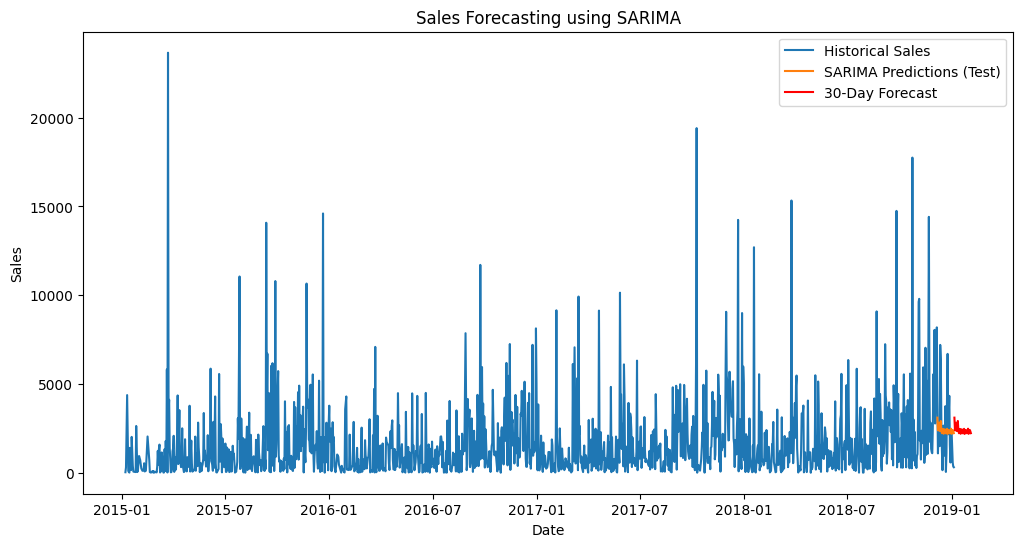

In [14]:
plt.figure(figsize=(12,6))

# Plot historical sales
plt.plot(df.index, df["Sales"], label="Historical Sales")

# Plot predictions on test set
plt.plot(test.index, preds, label="SARIMA Predictions (Test)")

# Plot 30-day forecast
plt.plot(future_pred.index, future_pred, label="30-Day Forecast", color='red')

plt.title("Sales Forecasting using SARIMA")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()
